
Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется sklearn) в подмодуле datasets через функцию, которая называется load_digits. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

(0.5 балла) Загрузите данные. Добейтесь, чтобы в переменной X оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной y – массив истинных меток классов, содержащий 1797 чисел.

Указания:

Как загрузить данные, объяснено в справке к функции load_digits.
Размер массива хранится в атрибуте shape.

(1797, 64)


<Figure size 432x288 with 0 Axes>

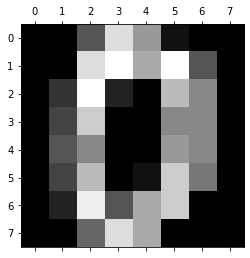

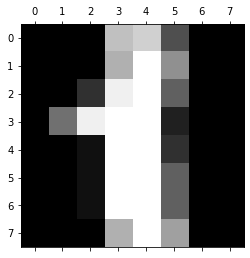

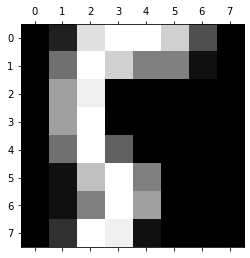

In [314]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

print(digits.data.shape)

import matplotlib.pyplot as plt 

#Посмотрим примеры
plt.gray() 
plt.matshow(digits.images[0]) 
plt.matshow(digits.images[1])
plt.matshow(digits.images[155])
plt.show() 

In [315]:
digits.data.shape

(1797, 64)

In [316]:
digits.target.shape

(1797,)


(1 балл) Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

Указания:

Не забудьте импортировать NumPy и Matplotlib.
Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией load_digits, либо сделать самостоятельно из строк массива X. Во втором случае пользуйтесь методом reshape.
Чтобы изображение не было цветным, можно вызвать функцию plt.gray, прежде чем начать рисовать.
Располагать картинки на сетке умеет функция plt.subplot. Ознакомьтесь со справкой к ней.
По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
Выводить картинку на экран умеет функция plt.imshow. Ознакомьтесь со справкой к ней.
Если считаете нужным, можете отключить сглаживание – параметр interpolation у функции plt.imshow.
Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции plt.xticks и plt.yticks.

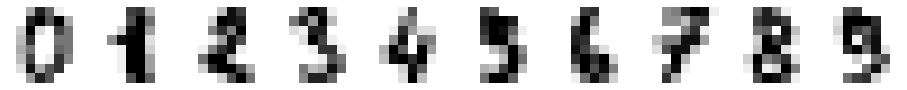

In [317]:
import numpy
#nrows=1 nrows=1
__, axes = plt.subplots(nrows=1, ncols=10, figsize=(16,6))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

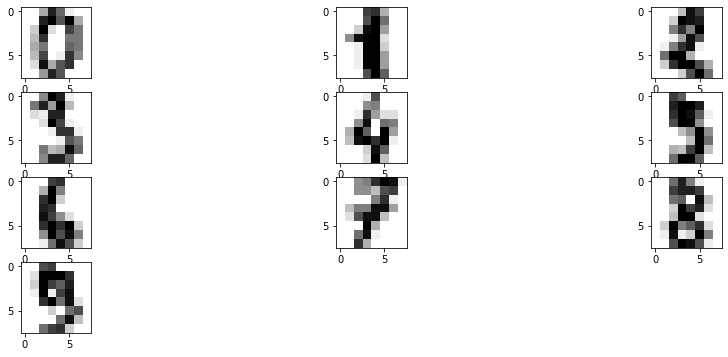

In [318]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(4, 3, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap=plt.cm.gray_r, interpolation='nearest');

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле cluster. Иерархическая кластеризация называется AgglomerativeClustering, а метод $K$ средних – KMeans.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:

Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется n_clusters, это количество кластеров, которое мы хотим получить на выходе.
Инициализированную модель можно обучить, вызвав метод fit.
С помощью обученной модели можно предсказывать, вызывая метод predict.
Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод fit_predict, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

(0.5 балла) Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива X на 10 кластеров.

Указания:

Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
KMeans делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр n_init в конструкторе.

In [319]:
#Метод K-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10, random_state = 0, n_init=100)
clusters = kmeans.fit_predict(X)
kmeans.cluster_centers_.shape


(10, 64)

In [320]:
#Иерархическая кластеризация
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage = 'ward')
pred = cluster.fit_predict(X)
pred.shape


(1797,)

In [321]:
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
centers

array([[[ 0.00000000e+00,  9.48275862e-01,  1.02298851e+01,
          1.44482759e+01,  7.74712644e+00,  9.77011494e-01,
         -6.66133815e-16,  0.00000000e+00],
        [ 2.29885057e-02,  5.27011494e+00,  1.37183908e+01,
          1.26206897e+01,  1.16724138e+01,  3.18965517e+00,
          1.72413793e-02, -1.38777878e-17],
        [ 1.14942529e-02,  4.58620690e+00,  8.12068966e+00,
          6.17241379e+00,  1.21839080e+01,  3.49425287e+00,
          1.72413793e-02, -1.38777878e-17],
        [-2.16840434e-19,  9.71264368e-01,  2.83333333e+00,
          7.04597701e+00,  1.25344828e+01,  2.54022989e+00,
          4.02298851e-02, -4.33680869e-19],
        [ 0.00000000e+00,  4.59770115e-02,  1.58045977e+00,
          9.93678161e+00,  1.06666667e+01,  1.43678161e+00,
          0.00000000e+00,  0.00000000e+00],
        [-1.73472348e-18,  2.52873563e-01,  4.48275862e+00,
          1.12356322e+01,  7.72413793e+00,  2.38505747e+00,
          8.50574713e-01,  1.14942529e-02],
        [ 2.6020

(1 балл) Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

Указания:

Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из X.
Чтобы выбрать наблюдения, входящие в кластер номер i, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа i оператором ==.
Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция np.mean. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

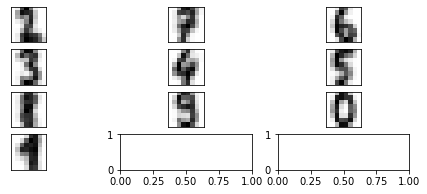

In [322]:
#Для K-means
fig, ax = plt.subplots(4, 3, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
  axi.set(xticks=[], yticks=[])
  axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [323]:
#Иерархическая кластеризация
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage = 'ward')
pred = cluster.fit_predict(X)
labels = cluster.labels_
labels

array([7, 9, 4, ..., 4, 1, 4], dtype=int64)

In [324]:
#Иерархическая кластеризация
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage = 'ward')
pred = cluster.fit_predict(X)
labels = cluster.labels_

import statistics
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [],[],[],[],[],[],[],[],[],[]
k = [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]

for lab in labels:
    if lab==0:
        k0.append(lab)
    elif lab==1:
        k1.append(lab)
    elif lab==2:
        k2.append(lab)
    elif lab==3:
        k3.append(lab)
    elif lab==4:
        k4.append(lab)
    elif lab==5:
        k5.append(lab)
    elif lab==6:
        k6.append(lab)
    elif lab==7:
        k7.append(lab)
    elif lab==8:
        k8.append(lab)
    else:
        k9.append(lab)

means = []
for i in k:
    st = statistics.mean(i)
    means.append(st)
    
print(f"Полученные центры кластеров для AgglomerativeClustering: {means}")

Полученные центры кластеров для AgglomerativeClustering: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией silhouette_score из подмодуля metrics. На вход нужно передать массив наблюдений и результат кластеризации.

(1.5 балла) Для числа $K$ от 2 до 20 включительно получите разбиение массива X на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

Указания:

Не забудьте, что функция range не захватывает правый конец диапазона.
Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
Рисовать графики умеет функция plt.plot. Ознакомьтесь со справкой к ней.
На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов plt.plot.
Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией plt.legend. Местоположение легенды контролируется параметром loc.
Чтобы подписать координатные оси, можно воспользоваться функциями plt.xlabel и plt.ylabel.

In [325]:
#Силуэт для k-means
from matplotlib.pyplot import plot
from sklearn import metrics
import numpy as np

scores = []
values = np.arange(2, 11)

#K-means
for num_clusters in values:
  kmeans = KMeans(init = 'k-means++', n_clusters = num_clusters, n_init = 10)
  kmeans.fit(X)
  score = metrics.silhouette_score(X, kmeans.labels_, metric = 'euclidean', sample_size = len(X))
  scores.append(score)


In [326]:
#Силуэт для AgglomerativeClustering
from sklearn import metrics
scores_agg = []
values = np.arange(2, 11)

#K-means
for num_clusters in values:
  model = AgglomerativeClustering (n_clusters = num_clusters, affinity = 'euclidean', linkage = 'ward') 
  model.fit (X) 
  score = metrics.silhouette_score(X, model.labels_, metric = 'euclidean', sample_size = len(X))
  scores_agg.append(score)


<function matplotlib.pyplot.show(close=None, block=None)>

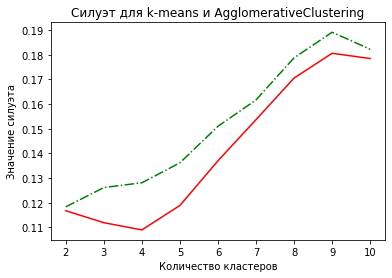

In [327]:
#Построим графики силуэта
plt.plot(values, scores, 'g-.', label='Силуэт для k-means') 
plt.plot(values, scores_agg, label='Силуэт для AgglomerativeClustering', color='red')
plt.title('Силуэт для k-means и AgglomerativeClustering')
plt.xlabel('Количество кластеров')
plt.ylabel('Значение силуэта')
plt.legend
plt.show

Лучшее значение силуэта для обоих методов достигается (как видно из графика) при количестве кластеров, равных 9. Посчитаем, чему будет равно значение силуэта при таком количестве кластеров.

In [328]:
#k-means
kmeans = KMeans(init = 'k-means++', n_clusters = 9, n_init = 10)
kmeans.fit(X)
print(metrics.silhouette_score(X, kmeans.labels_, metric = 'euclidean', sample_size = len(X)))

0.18896293029472921


In [329]:
#Посмотрим на AgglomerativeClustering
model = AgglomerativeClustering (n_clusters = 9, affinity = 'euclidean', linkage = 'ward') 
model.fit (X) 
print(metrics.silhouette_score(X, model.labels_, metric = 'euclidean', sample_size = len(X))) 

0.18061975703867697


При использовании силуэта для двух методов k-means и AgglomerativeClustering можно увидеть, что лучшее разбиение будет для k-means, но все равно значение силуэта плохое, 0.18 больше стремится к 0, нежели к 1.

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии энтропии распределения вероятностей; подробности излагаются в этой статье. На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив y), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле metrics, под названиями homogeneity_score, completeness_score, v_measure_score. Как вариант, можно использовать функцию homogeneity_completeness_v_measure, которая возвращает сразу тройку чисел.

(1 балл) Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [330]:
#Оценка v-мера для KMeans
from sklearn.metrics import v_measure_score
v_scores = []
values = np.arange(2, 11)

#K-means
for num_clusters in values:
  kmeans = KMeans(init = 'k-means++', n_clusters = num_clusters, n_init = 10)
  kmeans.fit(X)
  v_score = v_measure_score(y, kmeans.labels_)
  v_scores.append(v_score)

In [331]:
#Оценка v-мера для AgglomerativeClustering
from sklearn import metrics
v_scores_agg = []
values = np.arange(2, 11)

#K-means
for num_clusters in values:
  model = AgglomerativeClustering (n_clusters = num_clusters, affinity = 'euclidean', linkage = 'ward') 
  model.fit (X) 
  v_score_agg = v_measure_score(y, model.labels_)
  v_scores_agg.append(v_score_agg)


<function matplotlib.pyplot.show(close=None, block=None)>

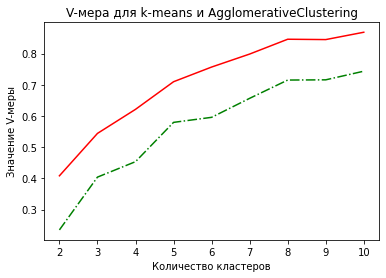

In [332]:
#Построим графики V-меры
plt.plot(values, v_scores, 'g-.', label='V-мера для k-means') 
plt.plot(values, v_scores_agg, label='V-мера для AgglomerativeClustering', color='red')
plt.xlabel('Количество кластеров')
plt.ylabel('Значение V-меры')
plt.title('V-мера для k-means и AgglomerativeClustering')
plt.legend
plt.show

При использровании v-меры наблюдаем хорошее разбиение при 10 кластерах. Посчитаем значения:

In [333]:
#k-means
kmeans = KMeans(init = 'k-means++', n_clusters = 10, n_init = 10)
kmeans.fit(X)
print(v_measure_score(y, kmeans.labels_))

0.7391783449350812


In [334]:
#AgglomerativeClustering
model = AgglomerativeClustering (n_clusters = 10, affinity = 'euclidean', linkage = 'ward') 
model.fit (X) 
print(v_measure_score(y, model.labels_))

0.8681701126909083


V-мера дает нам уже более приятные результаты, особенно для AgglomerativeClustering.

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:

отобрать (select) новые признаки из числа имеющихся;
извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.
Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, здесь (по-русски) или здесь (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс TruncatedSVD из подмодуля decomposition. В конструктор этого класса достаточно передать один параметр n_components – желаемое число новых признаков. Метод fit_transform принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм TruncatedSVD, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

(1.5 балла) Выполните сингулярное разложение матрицы X, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

<function matplotlib.pyplot.show(close=None, block=None)>

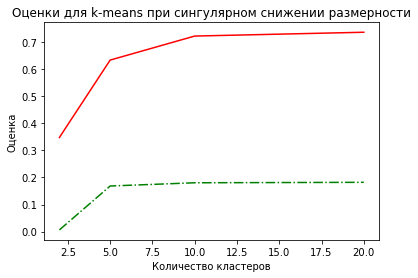

In [335]:
#Посмотрим на k-means
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.manifold import TSNE

n = [2, 5, 10, 20]
k_scores_SVD = []
k_scores_SVD_v = []

#Для k-means считаем силуэт и v-меру при сингулярном разложении
for k in [2, 5, 10, 20]:
  svd = TruncatedSVD(n_components=k, n_iter=7, random_state=42).fit_transform(X)
  kmeans = KMeans(init = 'k-means++', n_clusters = 10, n_init = 10)
  SVD_labels = kmeans.fit_predict(svd) 
  score = metrics.silhouette_score(X, SVD_labels, metric = 'euclidean', sample_size = len(X))
  k_scores_SVD.append(score)
  v_score_agg = v_measure_score(y, SVD_labels)
  k_scores_SVD_v.append(v_score_agg)
    

#Построим графики 
plt.plot(n, k_scores_SVD, 'g-.', label='Силуэт при сингулярном разложении, используя k-means') 
plt.plot(n, k_scores_SVD_v, label='V-мера для при сингулярном разложении, используя k-means', color='red')
plt.xlabel('Количество кластеров')
plt.ylabel('Оценка')
plt.title('Оценки для k-means при сингулярном снижении размерности')
plt.legend
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

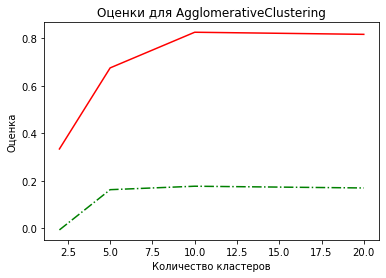

In [336]:
#Посмотрим на AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.manifold import TSNE

n = [2, 5, 10, 20]
agg_scores_SVD = []
agg_scores_SVD_v = []

#Для AgglomerativeClustering считаем силуэт и v-меру при сингулярном разложении
for k in [2, 5, 10, 20]:
  svd = TruncatedSVD(n_components=k, n_iter=7, random_state=42).fit_transform(X)
  model = AgglomerativeClustering (n_clusters = 10, affinity = 'euclidean', linkage = 'ward')
  agg_labels = model.fit_predict(svd) 
  score_agg = metrics.silhouette_score(X, agg_labels, metric = 'euclidean', sample_size = len(X))
  agg_scores_SVD.append(score_agg)
  v_score_agg = v_measure_score(y, agg_labels)
  agg_scores_SVD_v.append(v_score_agg)
    

#Построим графики 
plt.plot(n, agg_scores_SVD, 'g-.', label='Силуэт при сингулярном разложении, используя AgglomerativeClustering') 
plt.plot(n, agg_scores_SVD_v, label='V-мера для при сингулярном разложении, используя AgglomerativeClustering', color='red')
plt.xlabel('Количество кластеров')
plt.ylabel('Оценка')
plt.title('Оценки для AgglomerativeClustering')
plt.legend
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

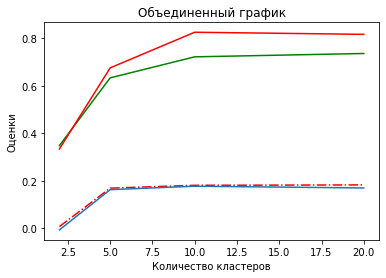

In [337]:
plt.plot(n, k_scores_SVD, 'r-.', label='Силуэт при сингулярном разложении, используя k-means') 
plt.plot(n, k_scores_SVD_v, label='V-мера для при сингулярном разложении, используя k-means', color='green')
plt.plot(n, agg_scores_SVD, label='Силуэт при сингулярном разложении, используя AgglomerativeClustering') 
plt.plot(n, agg_scores_SVD_v, label='V-мера для при сингулярном разложении, используя AgglomerativeClustering', color='red')
plt.xlabel('Количество кластеров')
plt.ylabel('Оценки')
plt.title('Объединенный график')
plt.legend
plt.show

Используя сингулярное разложение, можно увидеть, что силуэт как для k-means, так и для AgglomerativeClustering, будет не очень хорошим, его значение не высоко. Но при этом v-мера на наших значениях дает хороший результат. Для AgglomerativeClustering значение меры достигает максимума при разложении на 10 компонентов, далее ее значение падает. Для k-means с 10 компонентов идет медленный рост значения меры, и все же максимум достигается при 20 компонентах. Посчситаем их значения.

In [338]:
#k-means n_components=20
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42).fit_transform(X)
kmeans = KMeans(init = 'k-means++', n_clusters = 10, n_init = 10)
SVD_labels = kmeans.fit_predict(svd) 
print(v_measure_score(y, SVD_labels))

0.7403099789823891


In [339]:
#AgglomerativeClustering n_components=10
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42).fit_transform(X)
model = AgglomerativeClustering (n_clusters = 10, affinity = 'euclidean', linkage = 'ward')
agg_labels = model.fit_predict(svd) 
print(v_measure_score(y, agg_labels))


0.8259753348813222


Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, здесь, но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс TSNE в подмодуле manifold. В конструктор можно передать параметр n_components, а можно и не передавать: по умолчанию он равен 2. Метод fit_transform работает аналогично тому, как и у TruncatedSVD.

В последние годы вместо tSNE на практике часто используется UMAP, более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку umap-learn. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры n_neighbors и min_dist, которыми определяется вид проекции.

(0.5 балла) Выполните tSNE-преобразование матрицы X, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

Указания:

Точечную диаграмму умеет рисовать функция plt.scatter. Ознакомьтесь со справкой к ней.
За цвета точек отвечает параметр c у функции plt.scatter. Передать в него надо истинные метки классов.

<Figure size 864x864 with 0 Axes>

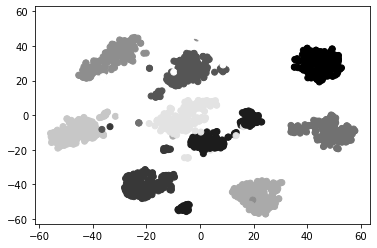

<Figure size 864x864 with 0 Axes>

In [340]:
X_embedded = TSNE(n_components=2).fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y)
plt.figure(figsize=(12, 12))

(1 балл) Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [341]:
#Посмотрим на k-means
X_embedded = TSNE(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=10)
TSNE_labels = kmeans.fit_predict(X_embedded) 
score_TSNE = metrics.silhouette_score(X, TSNE_labels, metric = 'euclidean', sample_size = len(X))
v_score_TSNE = v_measure_score(y, TSNE_labels)
print(f"Силуэт для k-means при tSNE-преобразованных данных: {score_TSNE}")  
print(f"V-мера для k-means при tSNE-преобразованных данных: {v_score_TSNE}")      

Силуэт для k-means при tSNE-преобразованных данных: 0.16373135521680124
V-мера для k-means при tSNE-преобразованных данных: 0.9032921512107855


In [342]:
#Посмотрим на AgglomerativeClustering
X_embedded = TSNE(n_components=2).fit_transform(X)
modelEgg = AgglomerativeClustering (n_clusters = 10, affinity = 'euclidean', linkage = 'ward') 
TSNE_labels_Agg = modelEgg.fit_predict(X_embedded) 
score_TSNE_Agg = metrics.silhouette_score(X, TSNE_labels_Agg, metric = 'euclidean', sample_size = len(X))
v_score_TSNE_Agg = v_measure_score(y, TSNE_labels_Agg)
print(f"Силуэт для AgglomerativeClustering при tSNE-преобразованных данных: {score_TSNE_Agg}")  
print(f"V-мера для AgglomerativeClustering при tSNE-преобразованных данных: {v_score_TSNE_Agg}")  

Силуэт для AgglomerativeClustering при tSNE-преобразованных данных: 0.1646742366318196
V-мера для AgglomerativeClustering при tSNE-преобразованных данных: 0.9089142744003061


Как видим, силуэт не дает нам хорошее разбиение, с этим лучше справляется v-мера. Так же при использовании tSNE мы получили очень хорошие результаты (если сравнивать даже с сингулярным разложением)

k-means: сингулярное разложение -0.7422729794392338, tSNE-преобразованных - 0.8854267441558161

AgglomerativeClustering: сингулярное разложение - 0.8259753348813222, tSNE-преобразованных - 0.9212977790343232


(0.5 балла) Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

# 4. Итоги, бонус

(1 балл) Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:

Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?


Из проведенной више работы могу сделать следующие выводы: у меня получилось, что метод иерархической кластеризации дал результаты лучше, чем метод к-средних. Результаты конечно не прям сильно различались, но все таки преимущество за AgglomerativeClustering. По критериям оценки могу сказать, что здесь очень большая разница была между силуэтом и мерой. V-мера давала каждый раз результат намного выше силуэта. По поводу разложения - сингулярное разложение снизило точность, зато tSNE показал самые крутые результаты. Из чего могу сделать вывод: качество кластеризации удалось улучшить, используя разложение tSNE.

(Бонусные 2 балла) Скачайте датасет MNIST Handwritten Digits. Как сделать это с помощью scikit-learn, написано здесь. MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [344]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [345]:
train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [346]:
y = train['label']
X = train.drop("label", axis=1)
print(X)

       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995       0       0       0       0       0       0       0       0       0   
41996       0       0       0       0       0       0       0       0       0   
41997       0       0       0       0       0       0       0       0       0   
41998       0       0       0       0       0       0       0       0       0   
41999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel77

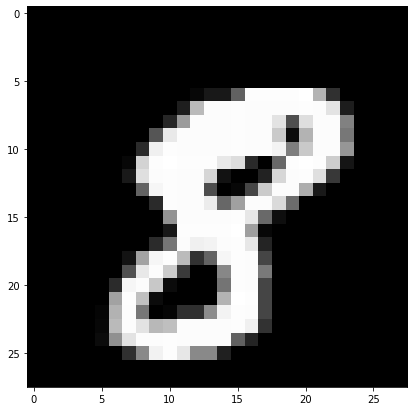

8


In [347]:
plt.figure(figsize=(7,7))
i = 10

grid_data = X.iloc[i].to_numpy().reshape(28,28)  # reshape from 1d to 2d pixel array
plt.imshow(grid_data, interpolation = "none", cmap = "gray")
plt.show()

print(y[i])

In [348]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.1, random_state=2)

In [349]:
print(X_train.shape)
print(X_val.shape)

(37800, 785)
(4200, 785)


In [350]:
#tSNE
X_embedded = TSNE(n_components=2).fit_transform(X_train)
modelEgg = AgglomerativeClustering (n_clusters = 10, affinity = 'euclidean', linkage = 'ward') 
TSNE_labels_Agg = modelEgg.fit_predict(X_embedded) 
score_TSNE_Agg = metrics.silhouette_score(X_train, TSNE_labels_Agg, metric = 'euclidean', sample_size = len(X))
v_score_TSNE_Agg = v_measure_score(y_train, TSNE_labels_Agg)
print(f"Силуэт для AgglomerativeClustering при tSNE-преобразованных данных: {score_TSNE_Agg}")  
print(f"V-мера для AgglomerativeClustering при tSNE-преобразованных данных: {v_score_TSNE_Agg}")  

Силуэт для AgglomerativeClustering при tSNE-преобразованных данных: 0.0339657315278926
V-мера для AgglomerativeClustering при tSNE-преобразованных данных: 0.7751964657597605


Силуэт для AgglomerativeClustering при tSNE-преобразованных данных: 0.0339657315278926

V-мера для AgglomerativeClustering при tSNE-преобразованных данных: 0.7751964657597605

C:\Users\Irisha-PC\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


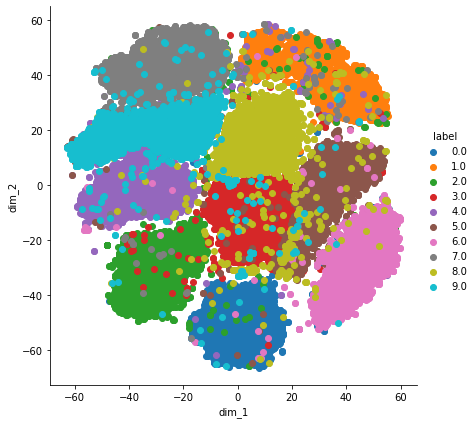

In [351]:
tsne=np.vstack((X_embedded.T, y_train)).T
data=pd.DataFrame(data=tsne,columns=("dim_1","dim_2", "label"))

sns.FacetGrid(data, hue="label", size=6).map(plt.scatter, "dim_1","dim_2").add_legend()
plt.show()

In [352]:
#поменяем настройки tSNE
X_embedded_new = TSNE(n_components=2, perplexity=50, n_iter=4000).fit_transform(X_train)
modelEgg = AgglomerativeClustering (n_clusters = 10, affinity = 'euclidean', linkage = 'ward') 
TSNE_labels_Agg = modelEgg.fit_predict(X_embedded_new) 
score_TSNE_Agg = metrics.silhouette_score(X_train, TSNE_labels_Agg, metric = 'euclidean', sample_size = len(X))
v_score_TSNE_Agg = v_measure_score(y_train, TSNE_labels_Agg)
print(f"Силуэт для AgglomerativeClustering при tSNE-преобразованных данных: {score_TSNE_Agg}")  
print(f"V-мера для AgglomerativeClustering при tSNE-преобразованных данных: {v_score_TSNE_Agg}")

Силуэт для AgglomerativeClustering при tSNE-преобразованных данных: 0.048785467166566426
V-мера для AgglomerativeClustering при tSNE-преобразованных данных: 0.8280467200498808


Силуэт для AgglomerativeClustering при tSNE-преобразованных данных: 0.048785467166566426

V-мера для AgglomerativeClustering при tSNE-преобразованных данных: 0.8280467200498808

C:\Users\Irisha-PC\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


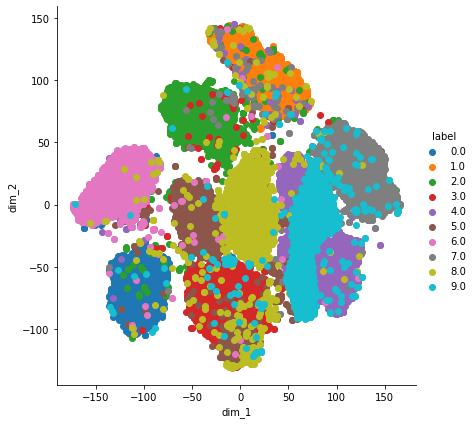

In [353]:
tsne=np.vstack((X_embedded_new.T, y_train)).T
data=pd.DataFrame(data=tsne,columns=("dim_1","dim_2", "label"))

sns.FacetGrid(data, hue="label", size=6).map(plt.scatter, "dim_1","dim_2").add_legend()
plt.show()